# 1. Setup and Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 2. Download 25+ Years of Data for SPY, QQQ, DIA

In [5]:
tickers = ['SPY', 'QQQ', 'DIA', '^VIX']
start_date = "2000-01-01"
end_date = "2025-05-31"

data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Check data

In [6]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2000-01-03,92.414948,94.202087,91.422092,94.202087,8164300
2000-01-04,88.800919,91.541197,88.731419,91.203627,8089800
2000-01-05,88.959785,89.932783,87.212361,88.920071,12177900
2000-01-06,87.530113,89.912966,87.530113,88.721539,6227200
2000-01-07,92.613510,92.613510,88.999518,89.158375,8066500


=== SPY - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2025-05-23,579.109985,581.809998,575.599976,575.979980,76029000
2025-05-27,591.150024,591.309998,578.429993,586.070007,72588500
2025-05-28,587.729980,592.770020,586.989990,591.559998,68445500
2025-05-29,590.049988,593.200012,586.070007,593.059998,69973300
2025-05-30,589.390015,591.130005,583.239990,588.929993,90601200


=== QQQ - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2000-01-03,80.314293,81.532782,76.923716,81.532782,36345200
2000-01-04,74.804634,79.254768,74.539745,77.983301,33786600
2000-01-05,72.897430,75.970142,71.414052,74.168897,42496600
2000-01-06,67.891014,74.592702,67.599636,73.639102,37134800
2000-01-07,76.288017,76.288017,69.930683,70.301527,28138200


=== QQQ - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2025-05-23,509.239990,511.839996,505.579987,506.179993,58368100
2025-05-27,521.219971,521.710022,514.590027,516.150024,47226300
2025-05-28,518.909973,523.679993,518.390015,522.179993,46637200
2025-05-29,519.929993,526.479980,517.320007,526.330017,58513300
2025-05-30,519.109985,520.679993,511.929993,519.440002,67662800


=== DIA - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,DIA,DIA,DIA,DIA,DIA
Date,,,,,
2000-01-03,65.827835,67.295912,65.537845,67.295912,1278800
2000-01-04,63.661976,65.519727,63.661976,65.120991,1535700
2000-01-05,64.486702,65.175430,63.236117,63.797974,2007000
2000-01-06,64.812897,65.637557,64.486657,64.613528,2639500
2000-01-07,66.987823,67.024072,65.664741,65.719115,3767400


=== DIA - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,DIA,DIA,DIA,DIA,DIA
Date,,,,,
2025-05-23,416.329987,418.170013,413.829987,413.940002,3117800
2025-05-27,423.850006,423.859985,419.190002,420.700012,3126600
2025-05-28,421.420013,424.829987,420.739990,423.730011,1790900
2025-05-29,422.459991,423.019989,418.579987,422.459991,2751400
2025-05-30,422.850006,424.269989,419.510010,422.160004,2957500


=== ^VIX - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2000-01-03,24.209999,26.150000,23.980000,24.360001,0
2000-01-04,27.010000,27.180000,24.799999,24.940001,0
2000-01-05,26.410000,29.000000,25.850000,27.980000,0
2000-01-06,25.730000,26.709999,24.700001,26.680000,0
2000-01-07,21.719999,25.170000,21.719999,25.139999,0


=== ^VIX - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2025-05-23,22.290001,25.530001,19.830000,20.139999,0
2025-05-27,18.959999,21.010000,18.950001,20.629999,0
2025-05-28,19.309999,19.430000,18.680000,19.209999,0
2025-05-29,19.180000,20.200001,18.110001,18.250000,0
2025-05-30,18.570000,20.549999,18.570000,19.610001,0


# 3. Calculate Technical Indicators (RSI, MACD, TSI, etc.)

In [7]:
import ta

def add_indicators(df):
    df = df.copy()

    close = df['Close'].squeeze()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=close, window=14).rsi()

    # MACD components
    macd = ta.trend.MACD(close=close)
    df['MACD_Line'] = macd.macd()
    df['Signal_Line'] = macd.macd_signal()
    df['MACD_Histogram'] = macd.macd_diff()

    # EMAs for reference
    df['EMA_3'] = ta.trend.EMAIndicator(close=close, window=3).ema_indicator()
    df['EMA_5'] = ta.trend.EMAIndicator(close=close, window=5).ema_indicator()

    return df

Add custom indicator TSI (Trend Strength Index) from TradingView

In [8]:
def trend_strength_index(close_prices, window=14):
    tsi_values = []
    close_array = close_prices.squeeze().astype(float).values  # Ensure 1D array

    for i in range(len(close_array)):
        if i + 1 < window:
            tsi_values.append(np.nan)
        else:
            price_window = close_array[i + 1 - window: i + 1]  # include index i
            index_window = np.arange(window)
            r, _ = pearsonr(index_window, price_window)
            tsi_values.append(r)

    return pd.Series(tsi_values, index=close_prices.index)

Apply TSI to each dataset (SPY, QQQ, DIA)

In [9]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]
    df = add_indicators(df)
    df['TSI'] = trend_strength_index(df['Close'], window=14)
    data[ticker] = df

Add VIX values to each dataset (SPY, QQQ, DIA)

In [10]:
# Ensure VIX is aligned by date and rename the close column for clarity
vix_data = data['^VIX'][['Close']].rename(columns={'Close': 'VIX'})

for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]

    # Merge VIX values using the index (which should be the date)
    df = df.merge(vix_data, left_index=True, right_index=True, how='left')

    # Store the updated DataFrame back into your dictionary
    data[ticker] = df

Add Next Day's Return Column

In [11]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    
    df = data[ticker]
    df['Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']
    df.dropna(inplace=True)
    data[ticker] = df

In [12]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,85.981239,88.244949,85.544383,88.244949,9409200,36.234423,-0.892216,-0.585329,-0.306887,87.157045,87.753219,-0.723621,26.000000,-0.002541
2000-02-22,85.762802,86.636514,84.849376,85.901802,16415400,35.654773,-1.063748,-0.681013,-0.382735,86.459924,87.089747,-0.837685,25.860001,0.011808
2000-02-23,86.775528,87.351384,85.464959,86.179815,12119000,40.414020,-1.105230,-0.765856,-0.339373,86.617726,86.985007,-0.904491,23.889999,-0.020137
2000-02-24,85.028114,87.073396,84.571401,86.854968,17375000,35.530710,-1.264529,-0.865591,-0.398938,85.822920,86.332710,-0.919248,24.379999,-0.003620
2000-02-25,84.720299,86.874794,84.591228,85.901796,10559900,34.734509,-1.399480,-0.972369,-0.427112,85.271609,85.795239,-0.935400,25.200001,0.020978


=== SPY - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,583.090027,586.619995,581.409973,582.659973,70860400,59.499778,10.879004,9.581684,1.297320,585.461492,586.369279,0.808336,20.280001,-0.006826
2025-05-23,579.109985,581.809998,575.599976,575.979980,76029000,56.292174,9.910020,9.647351,0.262669,582.285739,583.949514,0.686693,22.290001,0.020791
2025-05-27,591.150024,591.309998,578.429993,586.070007,72588500,62.821677,9.998368,9.717554,0.280814,586.717881,586.349684,0.620869,18.959999,-0.005785
2025-05-28,587.729980,592.770020,586.989990,591.559998,68445500,60.076236,9.680822,9.710208,-0.029386,587.223931,586.809783,0.491271,19.309999,0.003947
2025-05-29,590.049988,593.200012,586.070007,593.059998,69973300,61.311410,9.506781,9.669523,-0.162742,588.636959,587.889851,0.342391,19.180000,-0.001119


=== QQQ - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,83.440002,87.307380,83.440002,86.989514,25271200,53.291594,1.841872,1.762703,0.079169,84.580174,84.718769,0.692837,26.000000,0.003175
2000-02-22,83.704887,84.711465,81.585776,83.916798,37226200,53.801591,1.698858,1.749934,-0.051077,84.142531,84.380808,0.509479,25.860001,0.055696
2000-02-23,88.366920,89.002654,84.049232,84.492921,32170800,61.723160,1.939349,1.787817,0.151532,86.254726,85.709512,0.477303,23.889999,0.021583
2000-02-24,90.274101,90.532368,86.459703,88.896680,48868200,64.411563,2.257807,1.881815,0.375992,88.264413,87.231042,0.524100,24.379999,-0.022887
2000-02-25,88.207985,91.121762,88.049052,90.009229,32617600,59.533294,2.316763,1.968805,0.347958,88.236199,87.556690,0.504662,25.200001,-0.000600


=== QQQ - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,514.000000,517.710022,512.299988,513.659973,55607200,64.287173,13.604804,11.898940,1.705864,515.338819,515.575589,0.844457,20.280001,-0.009261
2025-05-23,509.239990,511.839996,505.579987,506.179993,58368100,60.139417,12.657579,12.050668,0.606911,512.289404,513.463723,0.750104,22.290001,0.023525
2025-05-27,521.219971,521.710022,514.590027,516.150024,47226300,66.072422,12.726872,12.185909,0.540964,516.754688,516.049139,0.696755,18.959999,-0.004432
2025-05-28,518.909973,523.679993,518.390015,522.179993,46637200,64.091481,12.451854,12.239098,0.212756,517.832330,517.002750,0.601718,19.309999,0.001966
2025-05-29,519.929993,526.479980,517.320007,526.330017,58513300,64.596238,12.175851,12.226448,-0.050598,518.881162,517.978498,0.479277,19.180000,-0.001577


=== DIA - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,DIA,DIA,DIA,DIA,DIA,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,59.415390,61.013359,59.270120,61.013359,1526700,30.331998,-1.251042,-1.014621,-0.236420,60.320133,60.775251,-0.904346,26.000000,0.005499
2000-02-22,59.742130,60.123463,58.688926,59.778448,1518800,32.676574,-1.321862,-1.076070,-0.245792,60.031132,60.430877,-0.914346,25.860001,-0.005469
2000-02-23,59.415390,60.141740,59.052215,59.833041,1558900,31.533720,-1.388349,-1.138525,-0.249823,59.723261,60.092382,-0.926350,23.889999,-0.002445
2000-02-24,59.270100,59.669592,57.853719,59.596957,4518700,31.014281,-1.436208,-1.198062,-0.238146,59.496680,59.818288,-0.922109,24.379999,-0.033701
2000-02-25,57.272614,58.961375,57.054709,58.452931,3316900,24.933328,-1.616681,-1.281786,-0.334895,58.384647,58.969730,-0.913472,25.200001,0.016011


=== DIA - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,DIA,DIA,DIA,DIA,DIA,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,418.820007,421.149994,417.369995,417.869995,2638600,54.260049,4.640880,3.894686,0.746195,420.723628,421.575427,0.730394,20.280001,-0.005945
2025-05-23,416.329987,418.170013,413.829987,413.940002,3117800,51.650940,4.050888,3.925926,0.124962,418.526807,419.826947,0.562244,22.290001,0.018063
2025-05-27,423.850006,423.859985,419.190002,420.700012,3126600,58.189709,4.142367,3.969214,0.173153,421.188407,421.167967,0.464270,18.959999,-0.005733
2025-05-28,421.420013,424.829987,420.739990,423.730011,1790900,55.574225,3.972987,3.969969,0.003018,421.304210,421.251982,0.289062,19.309999,0.002468
2025-05-29,422.459991,423.019989,418.579987,422.459991,2751400,56.475878,3.877966,3.951568,-0.073602,421.882101,421.654652,0.122473,19.180000,0.000923


=== ^VIX - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2000-01-03,24.209999,26.150000,23.980000,24.360001,0
2000-01-04,27.010000,27.180000,24.799999,24.940001,0
2000-01-05,26.410000,29.000000,25.850000,27.980000,0
2000-01-06,25.730000,26.709999,24.700001,26.680000,0
2000-01-07,21.719999,25.170000,21.719999,25.139999,0


=== ^VIX - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2025-05-23,22.290001,25.530001,19.830000,20.139999,0
2025-05-27,18.959999,21.010000,18.950001,20.629999,0
2025-05-28,19.309999,19.430000,18.680000,19.209999,0
2025-05-29,19.180000,20.200001,18.110001,18.250000,0
2025-05-30,18.570000,20.549999,18.570000,19.610001,0


# 4. Correlation Analysis

=== Correlation Analysis for SPY ===


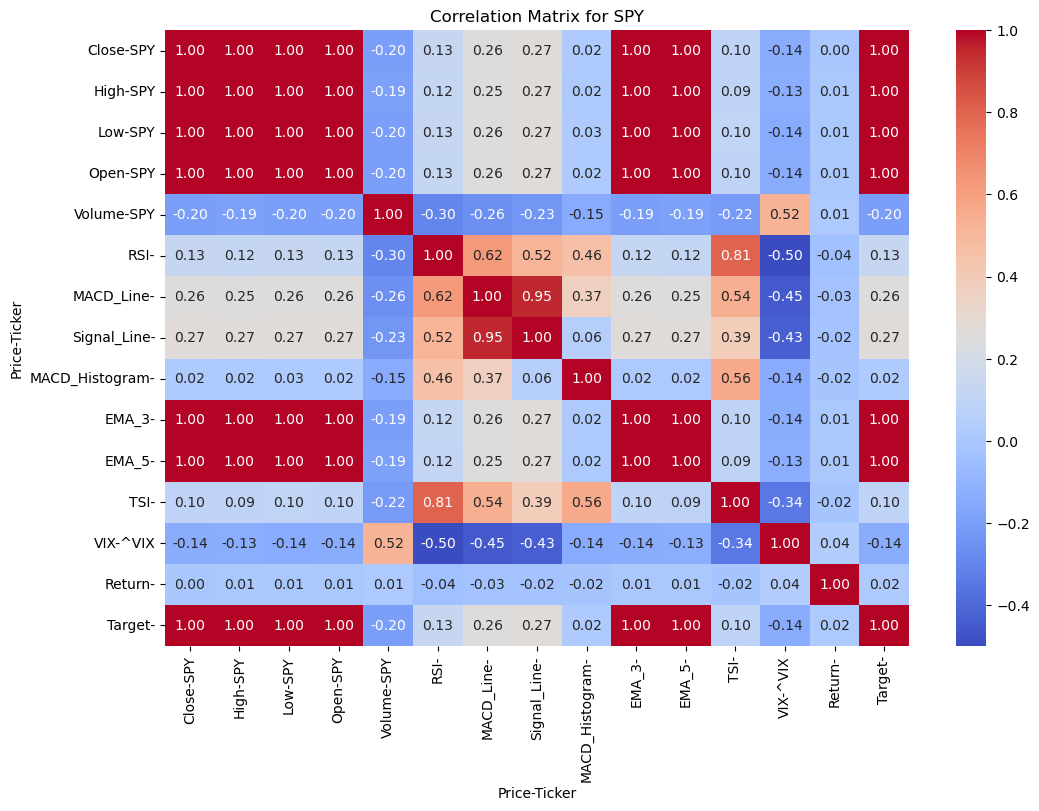

=== Correlation Analysis for QQQ ===


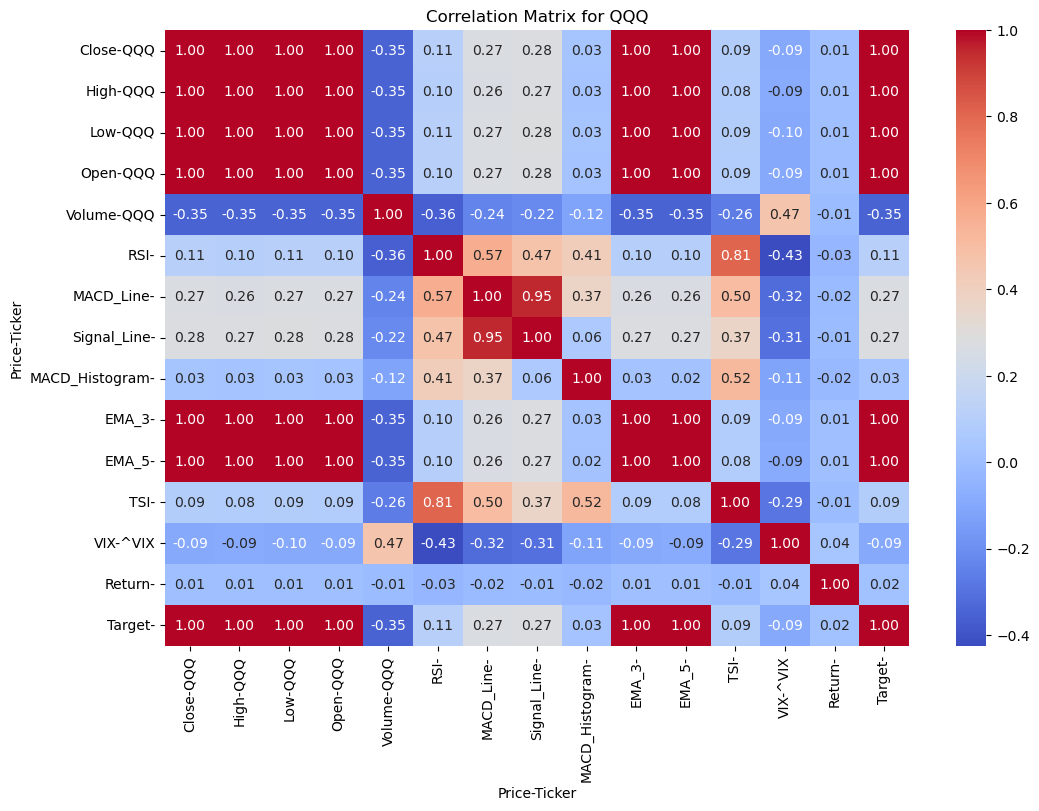

=== Correlation Analysis for DIA ===


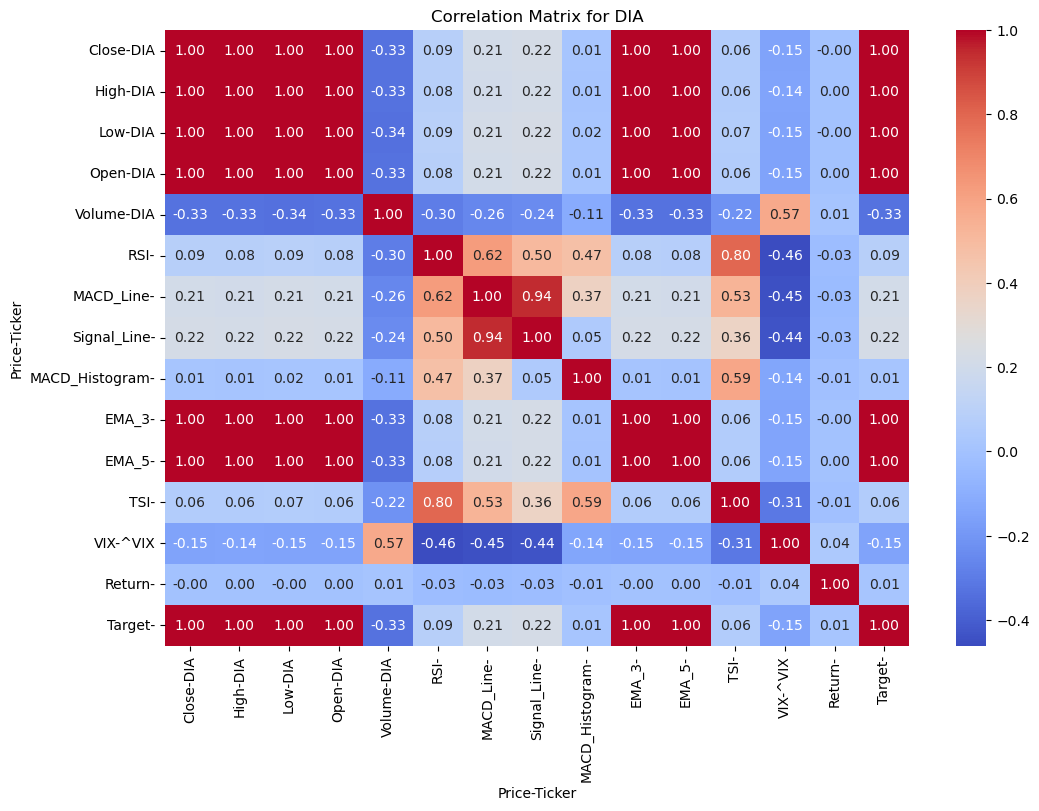

In [13]:
# Function to compute and plot correlation matrix
def plot_correlation_matrix(df, ticker):
    df = df.copy()
    
    # Drop rows with NaN values (especially from indicators and shift)
    df.dropna(inplace=True)
    
    # Add the target column (next day's closing price)
    df['Target'] = df['Close'].shift(-1)

    # Re-drop last row (now has NaN in Target)
    df.dropna(inplace=True)

    # Compute correlation matrix
    correlation = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Correlation Matrix for {ticker}')
    plt.show()

# Apply to all 3 tickers
for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"=== Correlation Analysis for {ticker} ===")
    plot_correlation_matrix(data[ticker], ticker)

# 5. Flatten MultiIndex Columns for Training

In [14]:
# ----------------------------
# A) FLATTEN MultiIndex columns
# ----------------------------
df_flat = data['SPY']  # or whatever ticker
df_flat.columns = df_flat.columns.get_level_values(0)
# Now df_flat.columns might look like:
#   ['Close','High','Low','Open','Volume','RSI','MACD_Line','Signal_Line','MACD_Histogram',
#    'EMA_3','EMA_5','TSI','VIX','Return']
#
# Replace data['SPY'] with this flattened version:
data['SPY'] = df_flat.copy()

# Repeat for QQQ and DIA:
for ticker in ['QQQ','DIA']:
    df_flat = data[ticker]
    df_flat.columns = df_flat.columns.get_level_values(0)
    data[ticker] = df_flat.copy()


# 6. Train XGBoost Model



=== TICKER: SPY ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=1.69, SE=2.85, APE=0.64%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.54, SE=2.37, APE=0.49%, R²_so_far=0.9605
Trained through 2021-02-19, forecasted 2021-02-22, AE=3.22, SE=10.39, APE=0.88%, R²_so_far=0.9754
Trained through 2021-07-14, forecasted 2021-07-15, AE=8.93, SE=79.76, APE=2.17%, R²_so_far=0.9861
Trained through 2021-12-03, forecasted 2021-12-06, AE=3.35, SE=11.25, APE=0.77%, R²_so_far=0.9906
Trained through 2022-04-28, forecasted 2022-04-29, AE=6.64, SE=44.11, APE=1.68%, R²_so_far=0.9922
Trained through 2022-09-21, forecasted 2022-09-22, AE=0.61, SE=0.38, APE=0.17%, R²_so_far=0.9918
Trained through 2023-02-14, forecasted 2023-02-15, AE=1.90, SE=3.61, APE=0.47%, R²_so_far=0.9916
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.84, SE=0.71, APE=0.19%, R²_so_far=0.9919
Trained through 2023-11-30, forecasted 2023-12-01, AE=

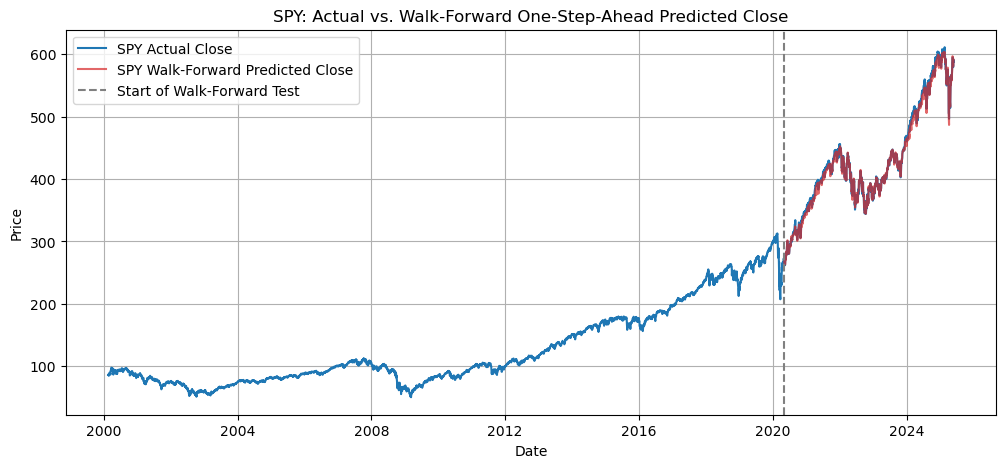

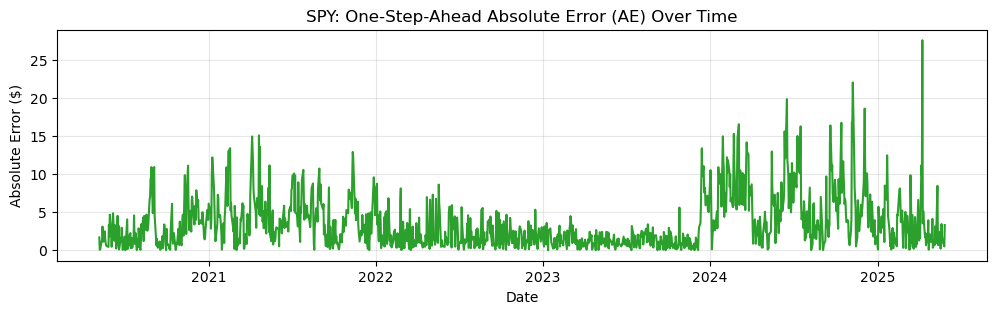

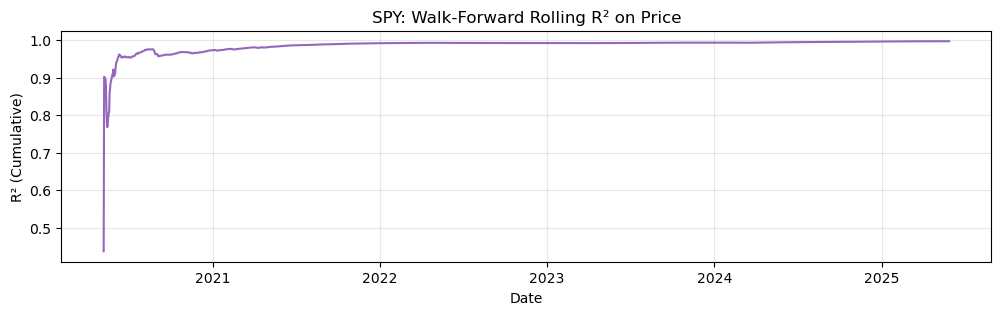



=== TICKER: QQQ ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=0.15, SE=0.02, APE=0.07%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.27, SE=1.60, APE=0.47%, R²_so_far=0.8678
Trained through 2021-02-19, forecasted 2021-02-22, AE=0.24, SE=0.06, APE=0.08%, R²_so_far=0.9540
Trained through 2021-07-14, forecasted 2021-07-15, AE=12.61, SE=158.93, APE=3.58%, R²_so_far=0.9733
Trained through 2021-12-03, forecasted 2021-12-06, AE=9.66, SE=93.35, APE=2.56%, R²_so_far=0.9842
Trained through 2022-04-28, forecasted 2022-04-29, AE=2.22, SE=4.92, APE=0.72%, R²_so_far=0.9860
Trained through 2022-09-21, forecasted 2022-09-22, AE=6.09, SE=37.14, APE=2.21%, R²_so_far=0.9860
Trained through 2023-02-14, forecasted 2023-02-15, AE=2.91, SE=8.47, APE=0.96%, R²_so_far=0.9873
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.90, SE=0.80, APE=0.24%, R²_so_far=0.9879
Trained through 2023-11-30, forecasted 2023-12-01, AE

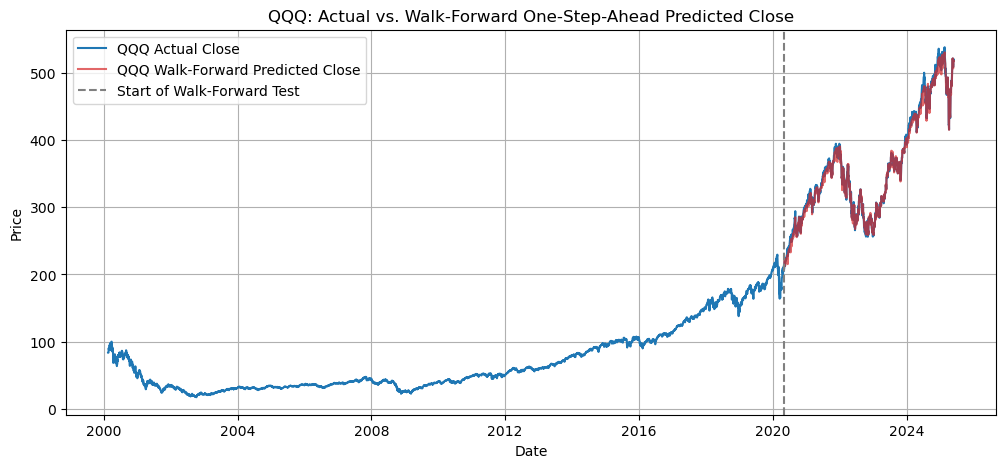

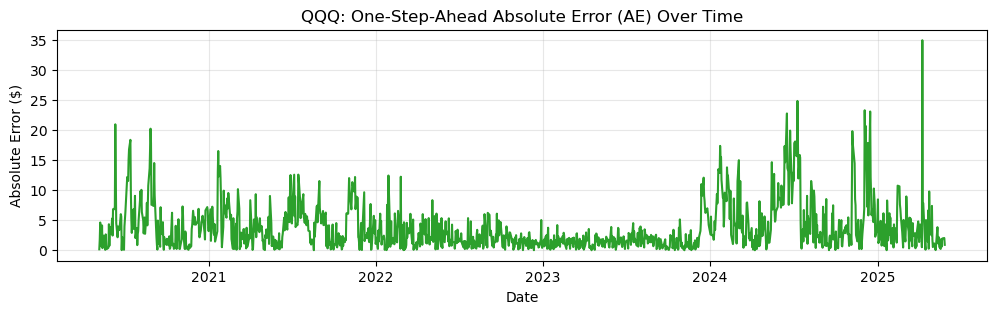

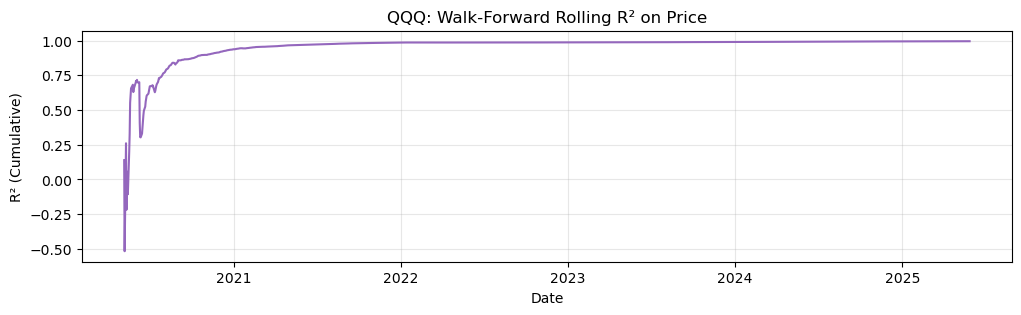



=== TICKER: DIA ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=0.35, SE=0.12, APE=0.16%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=0.58, SE=0.33, APE=0.23%, R²_so_far=0.9832
Trained through 2021-02-19, forecasted 2021-02-22, AE=3.57, SE=12.73, APE=1.22%, R²_so_far=0.9826
Trained through 2021-07-14, forecasted 2021-07-15, AE=2.88, SE=8.32, APE=0.88%, R²_so_far=0.9888
Trained through 2021-12-03, forecasted 2021-12-06, AE=3.71, SE=13.79, APE=1.12%, R²_so_far=0.9920
Trained through 2022-04-28, forecasted 2022-04-29, AE=5.20, SE=27.02, APE=1.66%, R²_so_far=0.9930
Trained through 2022-09-21, forecasted 2022-09-22, AE=1.22, SE=1.48, APE=0.42%, R²_so_far=0.9926
Trained through 2023-02-14, forecasted 2023-02-15, AE=0.29, SE=0.09, APE=0.09%, R²_so_far=0.9929
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.40, SE=0.16, APE=0.12%, R²_so_far=0.9932
Trained through 2023-11-30, forecasted 2023-12-01, AE=9

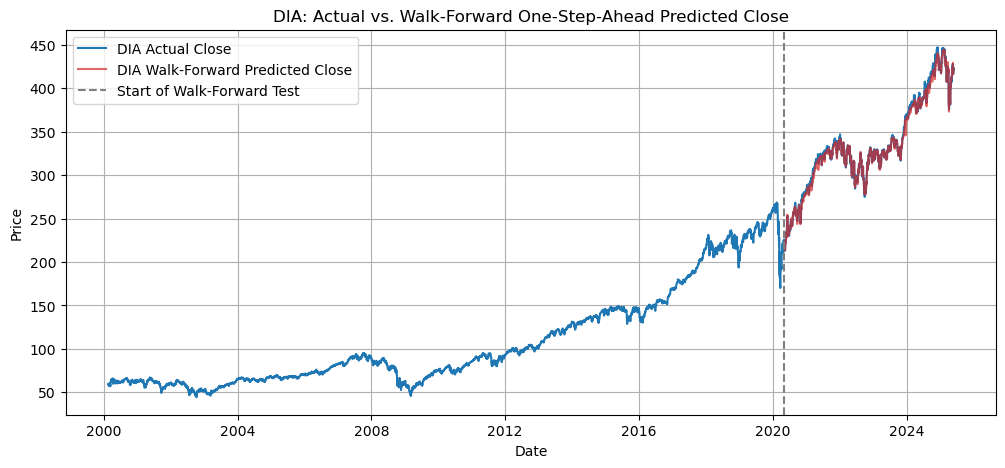

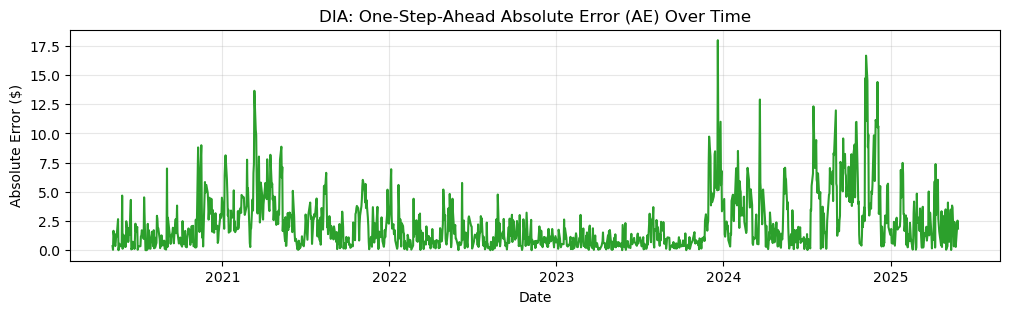

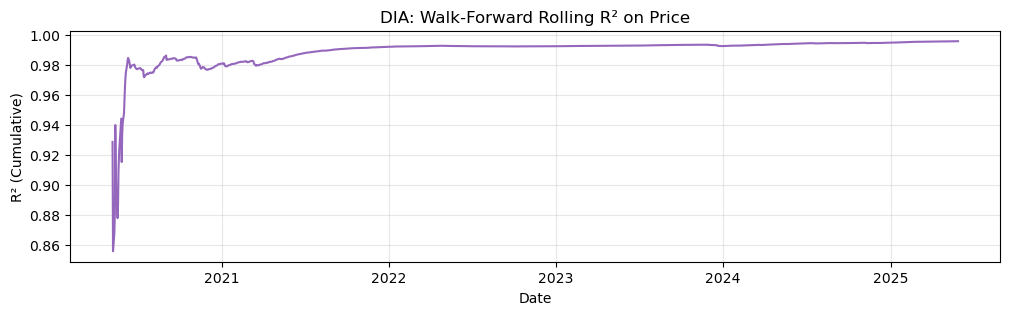

In [15]:
# List of tickers to process
tickers = ['SPY', 'QQQ', 'DIA']

# Features to use at each time t
features = [
    'Close','Open','High','Low','Volume',
    'EMA_3','EMA_5',
    'RSI','MACD_Histogram','TSI','VIX'
]

for ticker in tickers:
    print(f"\n\n=== TICKER: {ticker} ===")

    # ────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT‐DAY “CLOSE” FORECASTING
    # ────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()   # assume already flattened

    # 2) Create the next‐day‐close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3) Drop rows where TargetClose is NaN (i.e. the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk‐forward
    X_all   = df[features].values        # shape = (N, n_features)
    y_all   = df['TargetClose'].values    # shape = (N,)
    dates   = df.index                    # DatetimeIndex length = N

    # 5) Compute initial‐train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk   = pd.Series(data=np.nan, index=dates)   # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()                    # actual Close[t]

    #  We will store one‐step‐ahead errors (AE, SE, APE, R²) in lists
    ae_list   = []   # absolute error = |y_true - y_pred|
    se_list   = []   # squared error  = (y_true - y_pred)^2
    ape_list  = []   # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list   = []   # rolling R² (cumulative)
    date_list = []

    # ────────────────────────────────────────────────────────
    # (B) WALK‐FORWARD LOOP (EXPANDING WINDOW)
    # ────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (B.1) Extract train‐block [0 … day_idx-1] and test‐point = day_idx
        train_idx = np.arange(day_idx)       # [0, 1, …, day_idx-1]
        test_idx  = day_idx                  # single integer

        X_train = X_all[train_idx, :]        # features rows 0…day_idx-1
        y_train = y_all[train_idx]           # targets rows 0…day_idx-1

        X_test  = X_all[test_idx:test_idx+1, :]
        # shape = (1, n_features): features of row “day_idx” (to predict Close at day_idx+1)

        # (B.2) Scale features (fit on train, transform test)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # (B.3) Train XGBoost to predict TargetClose = Close(t+1)
        model = XGBRegressor(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=5,
            gamma=1,
            objective='reg:squarederror',
            random_state=42,
            verbosity=0
        )
        model.fit(X_train_scaled, y_train)

        # (B.4) One‐step‐ahead forecast: predict Close for next day
        y_pred_next_close = model.predict(X_test_scaled)[0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (B.5) Record errors for this “held‐out day_idx” 
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day   = abs(actual_c - y_pred_next_close)                   # absolute error
        se_day   = (actual_c - y_pred_next_close) ** 2                  # squared error
        ape_day  = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (B.6) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far     = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ────────────────────────────────────────────────────────
    # (C) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ────────────────────────────────────────────────────────

    # Build a small DataFrame of the walk‐forward errors
    errors_df = pd.DataFrame({
        'Date'    : date_list,
        'AE'      : ae_list,
        'SE'      : se_list,
        'APE'     : ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics:
    mean_mae   = np.mean(errors_df['AE'])
    mean_mse   = np.mean(errors_df['SE'])
    mean_rmse  = np.sqrt(mean_mse)
    mean_mape  = np.mean(errors_df['APE'])
    final_r2   = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK‐FORWARD SUMMARY <<<")
    print(f"One‐step‐ahead MAE:    {mean_mae:.4f}")
    print(f"One‐step‐ahead MSE:    {mean_mse:.4f}")
    print(f"One‐step‐ahead RMSE:   {mean_rmse:.4f}")
    print(f"One‐step‐ahead MAPE:   {mean_mape:.2f}%")
    print(f"One‐step‐ahead R²:     {final_r2:.4f}\n")

    # 1) Plot actual vs. predicted close (walk‐forward)
    plt.figure(figsize=(12,5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk‐Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk‐Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk‐Forward One‐Step‐Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day‐by‐day AE (MAE) over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One‐Step‐Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk‐Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()

# 7. LSTM Model



=== TICKER: SPY ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.029796
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.012299
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.015442
Best hyperparameters for SPY: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0022
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0013
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0014
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0012
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0012
Epoch 7/10
15

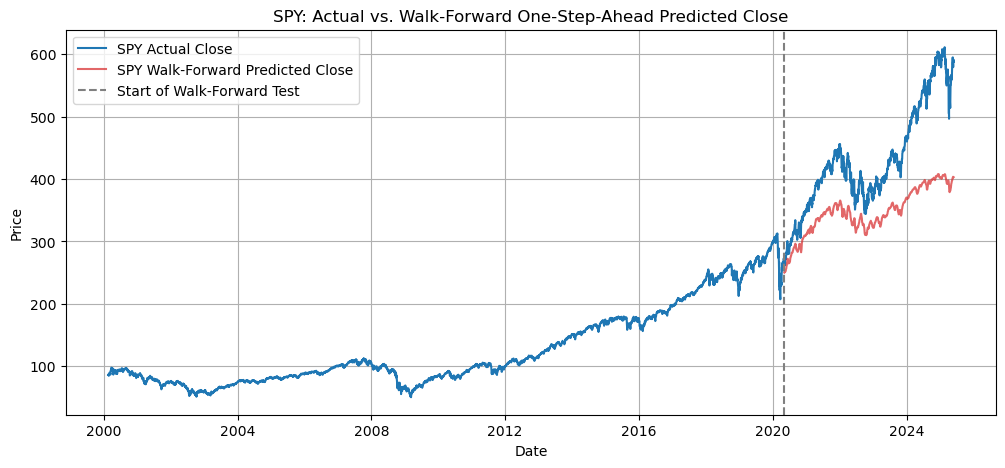

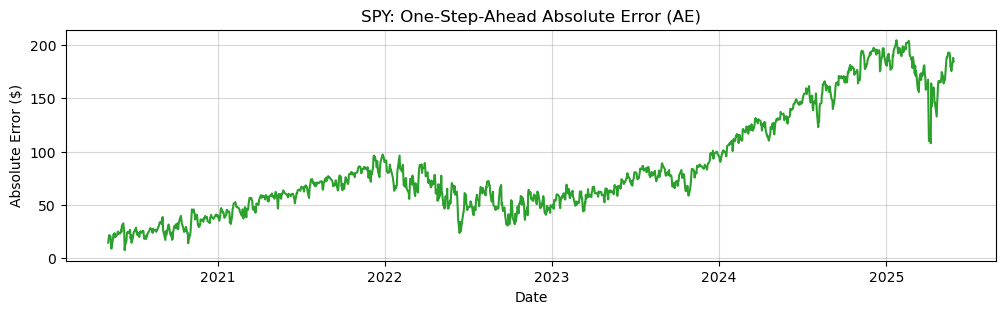

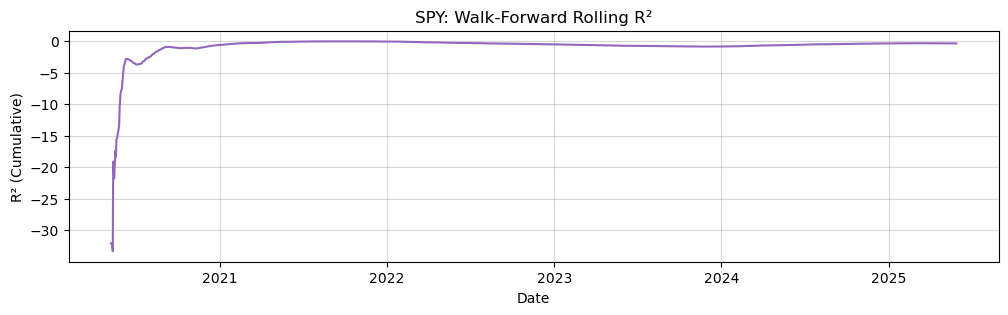



=== TICKER: QQQ ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.019912
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.015433
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.009590
Best hyperparameters for QQQ: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0017
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.7679e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.6815e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.0762e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.3590e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.6563e-04
Epoch 

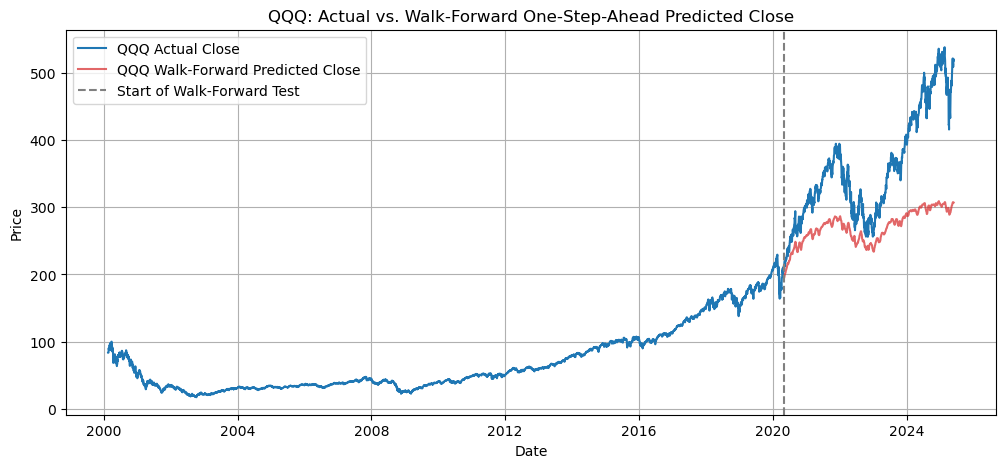

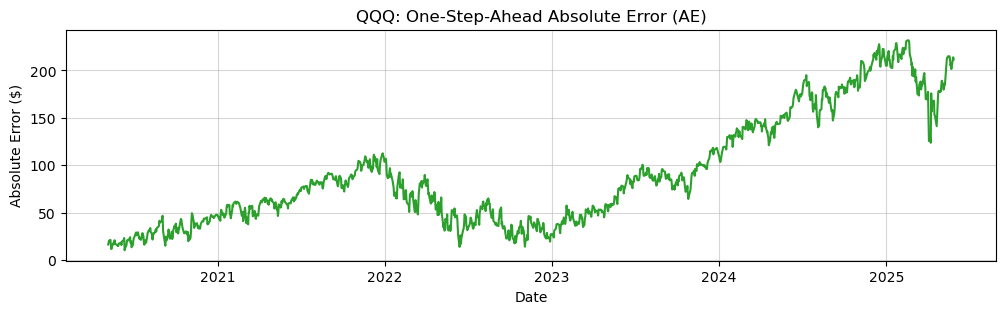

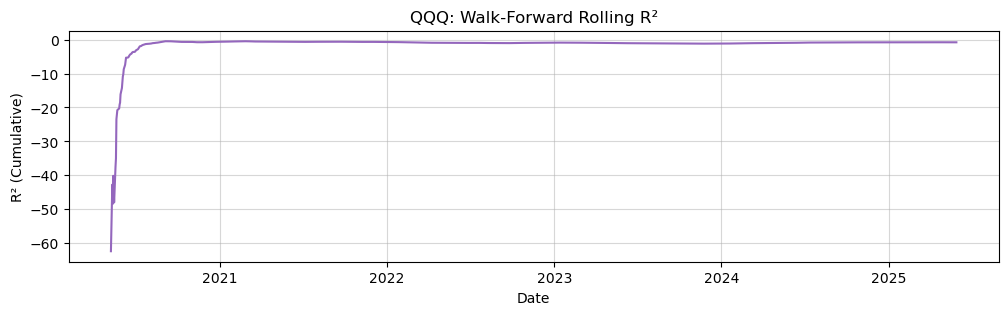



=== TICKER: DIA ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.030146
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.032268
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.021849
Best hyperparameters for DIA: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0016
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.2637e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.9453e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.3815e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.0855e-04
Epoch 7/10

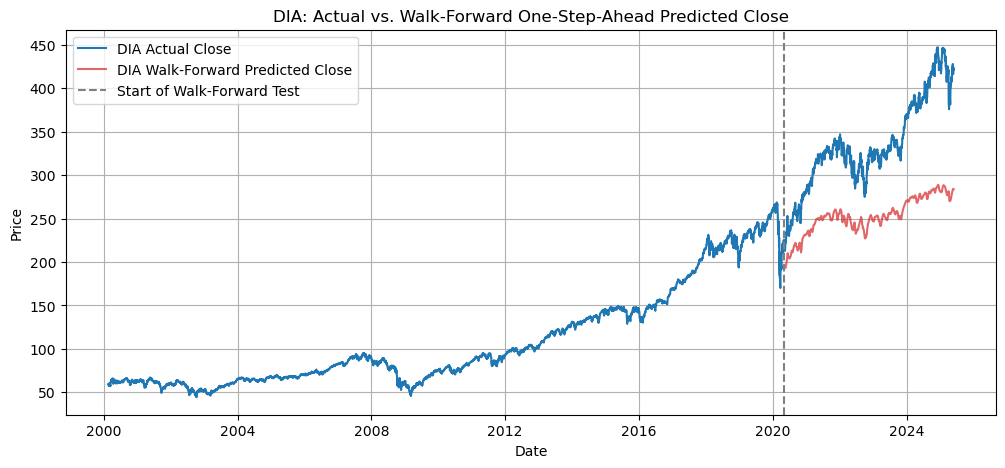

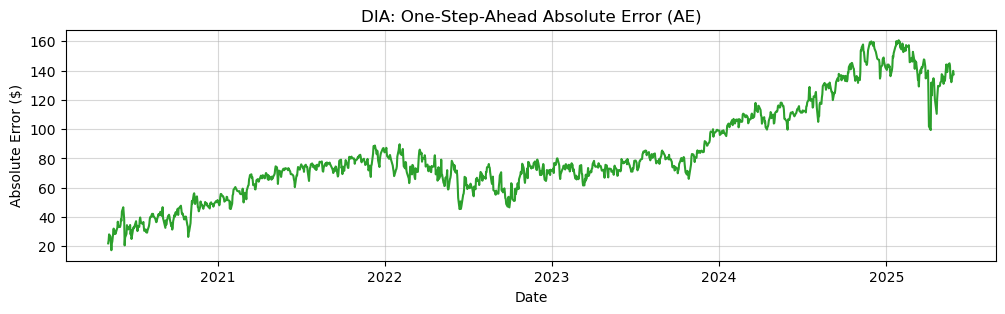

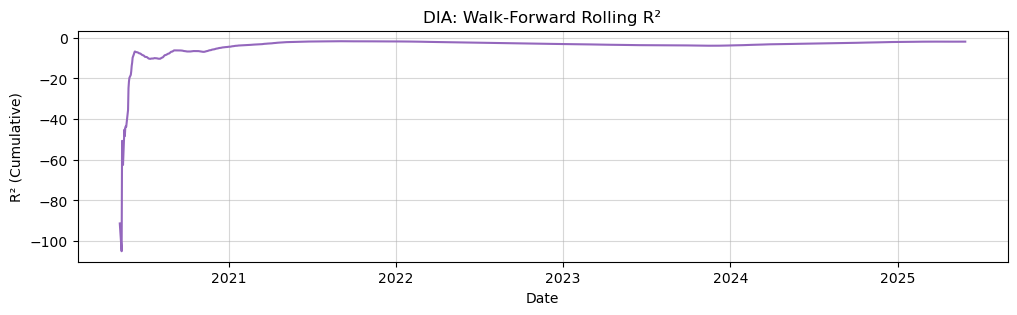

In [24]:
# 7. LSTM Model (Train-Once-and-Roll with Manual Hyperparameter Tuning)

from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Verify or define features list
try:
    features
except NameError:
    features = ['Close', 'Open', 'High', 'Low', 'Volume', 'EMA_3', 'EMA_5', 'RSI', 'MACD_Hist', 'TSI', 'VIX_Close']
    print("Features list was not defined; using default features.")

# LSTM settings
timesteps = 30
train_frac = 0.8
epochs = 10

# Build LSTM model
def build_lstm_model(units_1, units_2, dropout, learning_rate):
    model = Sequential([
        LSTM(units_1, input_shape=(timesteps, len(features)), return_sequences=True),
        Dropout(dropout),
        LSTM(units_2),
        Dropout(dropout),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    return model

# Manual hyperparameter tuning configurations
param_grid = [
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32},
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
]

for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"\n\n=== TICKER: {ticker} ===")

    # Check for missing values
    if data[ticker][features].isna().any().any():
        print(f"Warning: Missing values in {ticker}: {data[ticker][features].isna().sum()}")
        data[ticker][features] = data[ticker][features].fillna(method='ffill')

    # Prepare DataFrame
    df = data[ticker].copy()
    df['TargetClose'] = df['Close'].shift(-1)
    df.dropna(subset=['TargetClose'], inplace=True)
    
    X = df[features].values
    y = df['TargetClose'].values
    dates = df.index
    N = len(df)
    split = int(train_frac * N)
    print(f"Total days: {N:,} | Initial train size: {split:,}")

    # Scale data
    feat_scaler = MinMaxScaler().fit(X[:split])
    targ_scaler = MinMaxScaler().fit(y[:split].reshape(-1,1))
    Xs = feat_scaler.transform(X)
    ys = targ_scaler.transform(y.reshape(-1,1)).ravel()
    
    # Build training sequences
    X_train_seq, y_train_seq = [], []
    for i in range(timesteps, split):
        X_train_seq.append(Xs[i-timesteps:i])
        y_train_seq.append(ys[i])
    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)
    
    # Manual hyperparameter tuning
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    val_split = int(0.8 * len(X_train_seq))  # Use last 20% of training for validation
    
    for params in param_grid:
        print(f"Trying params: {params}")
        model = build_lstm_model(
            params['units_1'], params['units_2'], params['dropout'], params['learning_rate']
        )
        model.fit(
            X_train_seq[:val_split], y_train_seq[:val_split],
            epochs=5, batch_size=params['batch_size'], verbose=0,
            validation_data=(X_train_seq[val_split:], y_train_seq[val_split:])
        )
        val_loss = model.evaluate(X_train_seq[val_split:], y_train_seq[val_split:], verbose=0)
        print(f"Validation loss: {val_loss:.6f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
    
    print(f"Best hyperparameters for {ticker}: {best_params}")
    
    # Train best model on full training data
    best_model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=best_params['batch_size'], verbose=1)
    
    # Walk-forward forecasting
    window = deque(Xs[split-timesteps:split], maxlen=timesteps)
    preds, trues, pred_dates, ape_list, se_list = [], [], [], [], []  # Reinitialize lists
    
    for i in range(split, N):
        x_in = np.array(window).reshape(1, timesteps, X.shape[1])
        y_pred_s = best_model.predict(x_in, verbose=0)[0,0]
        y_pred = targ_scaler.inverse_transform([[y_pred_s]])[0,0]
        
        preds.append(y_pred)
        actual_c = df['Close'].iloc[i]
        trues.append(actual_c)
        pred_dates.append(dates[i])
        
        # Compute errors
        ae = abs(actual_c - y_pred)
        se = (actual_c - y_pred) ** 2
        ape = ae / abs(actual_c) * 100 if actual_c != 0 else 0
        ape_list.append(ape)
        se_list.append(se)
        
        window.append(Xs[i])
        
        # Print progress every 100 days
        if (i - split) % 100 == 1:
            print(f"Forecasted {dates[i].date()}, AE={ae:.2f}, APE={ape:.2f}%")
    
    # Compute metrics
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mape = np.nanmean(ape_list)
    r2 = r2_score(trues, preds)
    pearson_corr, _ = pearsonr(trues, preds)
    print(f"\n>>> {ticker} WALK-FORWARD TEST SUMMARY <<<")
    print(f"One-step-ahead MAE:    {mae:.2f}")
    print(f"One-step-ahead MSE:    {mse:.2f}")
    print(f"One-step-ahead RMSE:   {rmse:.2f}")
    print(f"One-step-ahead MAPE:   {mape:.2f}%")
    print(f"One-step-ahead R²:     {r2:.4f}")
    print(f"One-step-ahead Pearson: {pearson_corr:.2f}\n")
    
    # Create error DataFrame
    errors_df = pd.DataFrame({
        'Date': pred_dates,
        'AE': [abs(t - p) for t, p in zip(trues, preds)],
        'SE': se_list,
        'APE': ape_list,
        'R2_so_far': [r2_score(trues[:i+1], preds[:i+1]) if i > 1 else np.nan for i in range(len(preds))]
    }).set_index('Date')
    
    # Plots (match XGBoost, full actual close with predictions only for test period)
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Close'], label=f"{ticker} Actual Close", color='tab:blue')
    plt.plot(pred_dates, preds, label=f"{ticker} Walk-Forward Predicted Close", color='tab:red', alpha=0.7)
    plt.axvline(dates[split], color='gray', linestyle='--', label='Start of Walk-Forward Test')
    plt.title(f"{ticker}: Actual vs. Walk-Forward One-Step-Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One-Step-Ahead Absolute Error (AE)")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(True, alpha=0.5)
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk-Forward Rolling R²")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(True, alpha=0.5)
    plt.show()

# 8. GRU Model



=== TICKER: SPY ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.005041
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.003057
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.006886
Best hyperparameters for SPY: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0019
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0014
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0014
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0012
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0012
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0011
Epoch 7/10
15

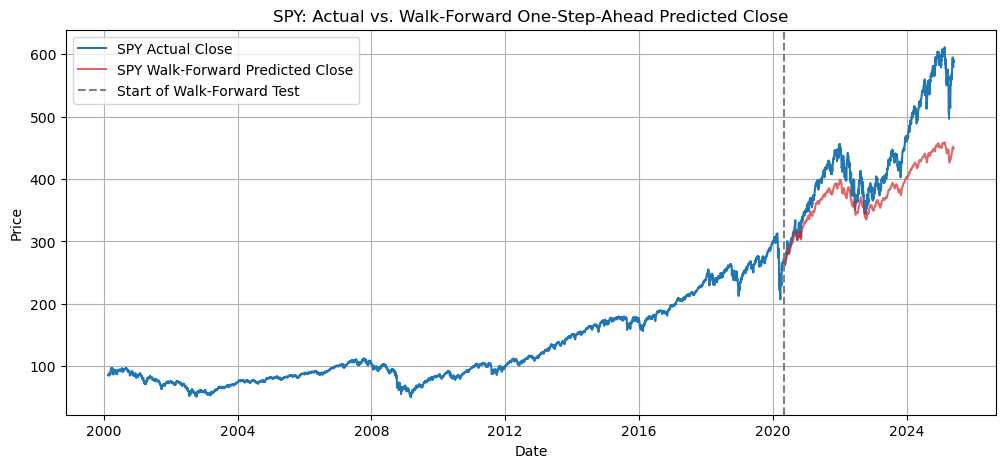

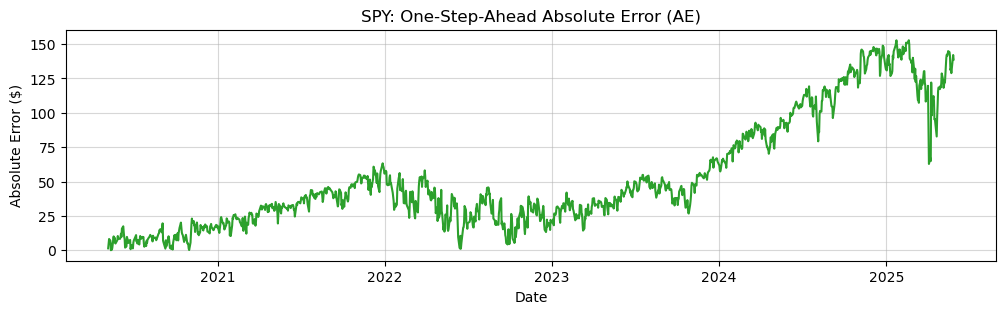

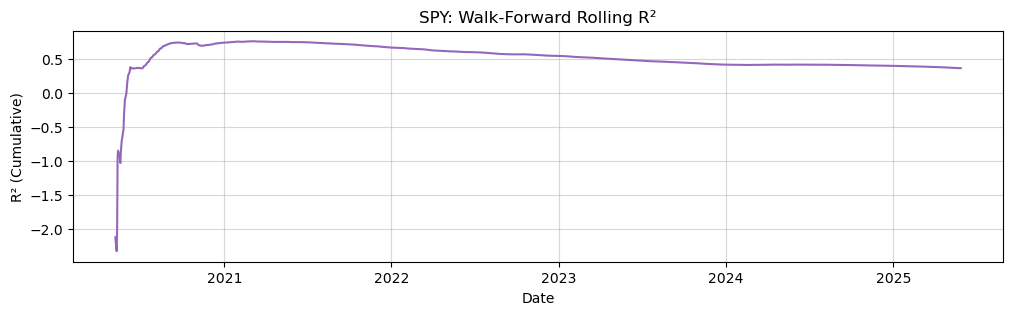



=== TICKER: QQQ ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.005641
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.006675
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.005856
Best hyperparameters for QQQ: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 8.3495e-04
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 7.7037e-04
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 7.6204e-04
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6.0030e-04
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 6.647

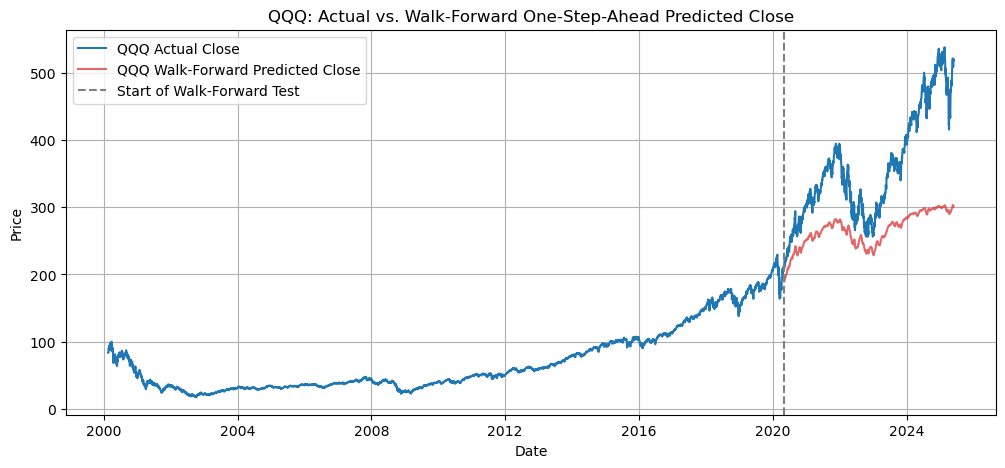

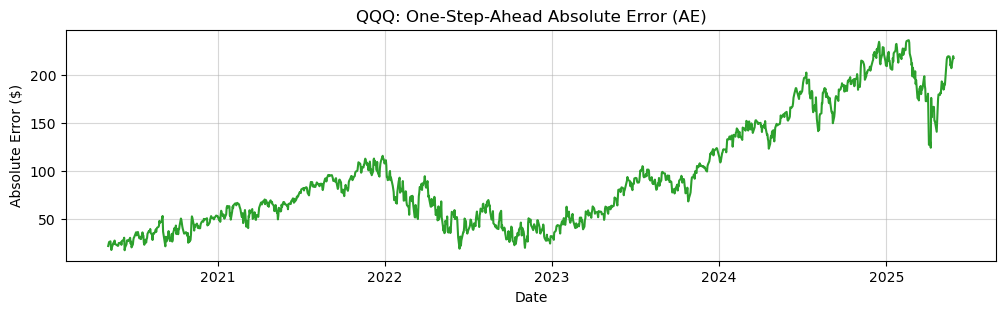

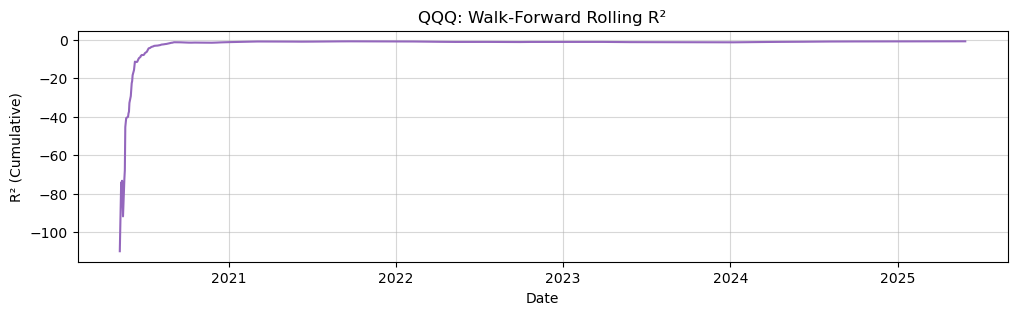



=== TICKER: DIA ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.009089
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.001488
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.007297
Best hyperparameters for DIA: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0021
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0017
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0016
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0013
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0012
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0013
Epoch 7/10
15

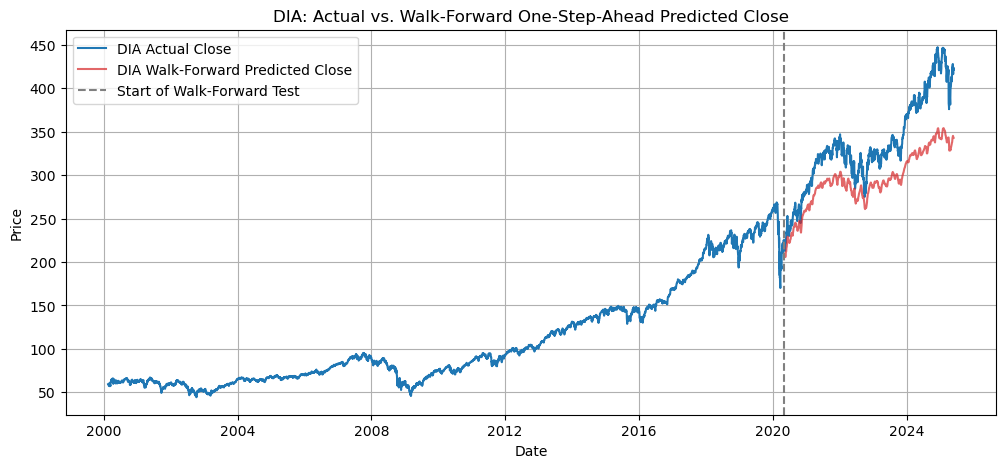

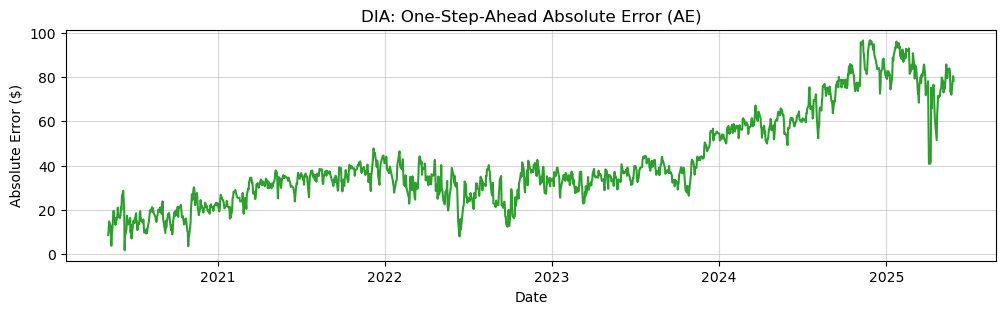

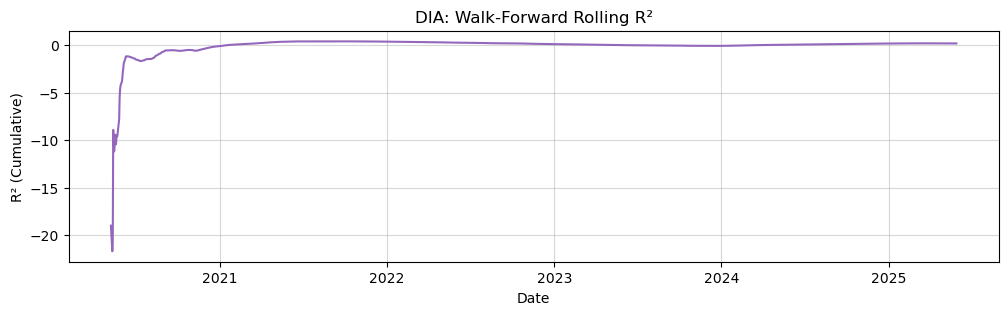

In [25]:
# 8. GRU Model (Train-Once-and-Roll with Manual Hyperparameter Tuning)

from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Verify or define features list
try:
    features
except NameError:
    features = ['Close', 'Open', 'High', 'Low', 'Volume', 'EMA_3', 'EMA_5', 'RSI', 'MACD_Hist', 'TSI', 'VIX_Close']
    print("Features list was not defined; using default features.")

# GRU settings
timesteps = 30
train_frac = 0.8
epochs = 10

# Build GRU model
def build_gru_model(units_1, units_2, dropout, learning_rate):
    model = Sequential([
        GRU(units_1, input_shape=(timesteps, len(features)), return_sequences=True),
        Dropout(dropout),
        GRU(units_2),
        Dropout(dropout),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    return model

# Manual hyperparameter tuning configurations
param_grid = [
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32},
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
]

for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"\n\n=== TICKER: {ticker} ===")

    # Check for missing values
    if data[ticker][features].isna().any().any():
        print(f"Warning: Missing values in {ticker}: {data[ticker][features].isna().sum()}")
        data[ticker][features] = data[ticker][features].fillna(method='ffill')

    # Prepare DataFrame
    df = data[ticker].copy()
    df['TargetClose'] = df['Close'].shift(-1)
    df.dropna(subset=['TargetClose'], inplace=True)
    
    X = df[features].values
    y = df['TargetClose'].values
    dates = df.index
    N = len(df)
    split = int(train_frac * N)
    print(f"Total days: {N:,} | Initial train size: {split:,}")

    # Scale data
    feat_scaler = MinMaxScaler().fit(X[:split])
    targ_scaler = MinMaxScaler().fit(y[:split].reshape(-1,1))
    Xs = feat_scaler.transform(X)
    ys = targ_scaler.transform(y.reshape(-1,1)).ravel()
    
    # Build training sequences
    X_train_seq, y_train_seq = [], []
    for i in range(timesteps, split):
        X_train_seq.append(Xs[i-timesteps:i])
        y_train_seq.append(ys[i])
    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)
    
    # Manual hyperparameter tuning
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    val_split = int(0.8 * len(X_train_seq))  # Use last 20% of training for validation
    
    for params in param_grid:
        print(f"Trying params: {params}")
        model = build_gru_model(
            params['units_1'], params['units_2'], params['dropout'], params['learning_rate']
        )
        model.fit(
            X_train_seq[:val_split], y_train_seq[:val_split],
            epochs=5, batch_size=params['batch_size'], verbose=0,
            validation_data=(X_train_seq[val_split:], y_train_seq[val_split:])
        )
        val_loss = model.evaluate(X_train_seq[val_split:], y_train_seq[val_split:], verbose=0)
        print(f"Validation loss: {val_loss:.6f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
    
    print(f"Best hyperparameters for {ticker}: {best_params}")
    
    # Train best model on full training data
    best_model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=best_params['batch_size'], verbose=1)
    
    # Walk-forward forecasting
    window = deque(Xs[split-timesteps:split], maxlen=timesteps)
    preds, trues, pred_dates, ape_list, se_list = [], [], [], [], []  # Reinitialize lists
    
    for i in range(split, N):
        x_in = np.array(window).reshape(1, timesteps, X.shape[1])
        y_pred_s = best_model.predict(x_in, verbose=0)[0,0]
        y_pred = targ_scaler.inverse_transform([[y_pred_s]])[0,0]
        
        preds.append(y_pred)
        actual_c = df['Close'].iloc[i]
        trues.append(actual_c)
        pred_dates.append(dates[i])
        
        # Compute errors
        ae = abs(actual_c - y_pred)
        se = (actual_c - y_pred) ** 2
        ape = ae / abs(actual_c) * 100 if actual_c != 0 else 0
        ape_list.append(ape)
        se_list.append(se)
        
        window.append(Xs[i])
        
        # Print progress every 100 days
        if (i - split) % 100 == 1:
            print(f"Forecasted {dates[i].date()}, AE={ae:.2f}, APE={ape:.2f}%")
    
    # Compute metrics
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mape = np.nanmean(ape_list)
    r2 = r2_score(trues, preds)
    pearson_corr, _ = pearsonr(trues, preds)
    print(f"\n>>> {ticker} WALK-FORWARD TEST SUMMARY <<<")
    print(f"One-step-ahead MAE:    {mae:.2f}")
    print(f"One-step-ahead MSE:    {mse:.2f}")
    print(f"One-step-ahead RMSE:   {rmse:.2f}")
    print(f"One-step-ahead MAPE:   {mape:.2f}%")
    print(f"One-step-ahead R²:     {r2:.4f}")
    print(f"One-step-ahead Pearson: {pearson_corr:.2f}\n")
    
    # Create error DataFrame
    errors_df = pd.DataFrame({
        'Date': pred_dates,
        'AE': [abs(t - p) for t, p in zip(trues, preds)],
        'SE': se_list,
        'APE': ape_list,
        'R2_so_far': [r2_score(trues[:i+1], preds[:i+1]) if i > 1 else np.nan for i in range(len(preds))]
    }).set_index('Date')
    
    # Plots (match XGBoost, full actual close with predictions only for test period)
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Close'], label=f"{ticker} Actual Close", color='tab:blue')
    plt.plot(pred_dates, preds, label=f"{ticker} Walk-Forward Predicted Close", color='tab:red', alpha=0.7)
    plt.axvline(dates[split], color='gray', linestyle='--', label='Start of Walk-Forward Test')
    plt.title(f"{ticker}: Actual vs. Walk-Forward One-Step-Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One-Step-Ahead Absolute Error (AE)")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(True, alpha=0.5)
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk-Forward Rolling R²")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(True, alpha=0.5)
    plt.show()